In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

print(f(3.0))

20.0


In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

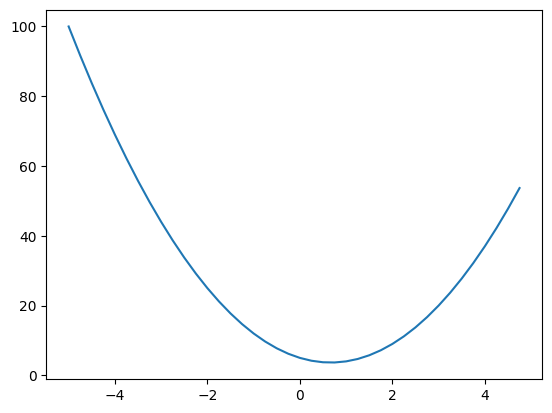

In [6]:
ys = f(xs)
plt.plot(xs, ys)

In [10]:
h = 0.000001
x = 2/3
slope = (f(x + h) - f(x))/h
slope

2.999378523327323e-06

In [15]:
a = 2.0
b = -3.0
c = 10.0

d = a * b + c

c += h

d2 = a * b + c

print('d1', d)
print('d2', d2)
print ('slope', (d2 - d)/h)

d1 4.0
d2 4.000000999999999
slope 0.9999999992515995


In [9]:
class Value:
    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(self):
            if self not in visited:
                visited.add(self)
                for child in self._prev:
                    build_topo(child)
                topo.append(self)
        build_topo(self)

        for node in reversed(topo):
            node._backward()

    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')

c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')

L = d * f; L.label = 'L'

d.grad = -2.0
f.grad = 4.0
c.grad = d.grad * 1.0
e.grad = d.grad * 1.0
a.grad = b.data * e.grad
b.grad = a.data * e.grad


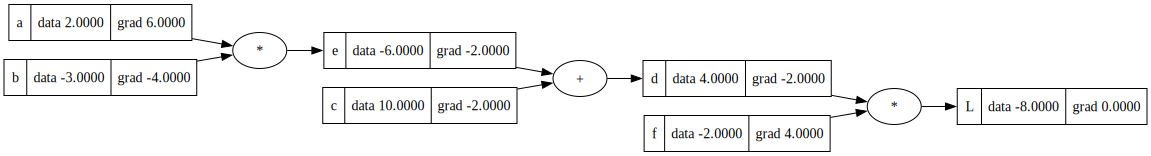

In [2]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            dot.node(name=uid + n._op, label=n._op)

            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

draw_dot(L)


6.000000000128124


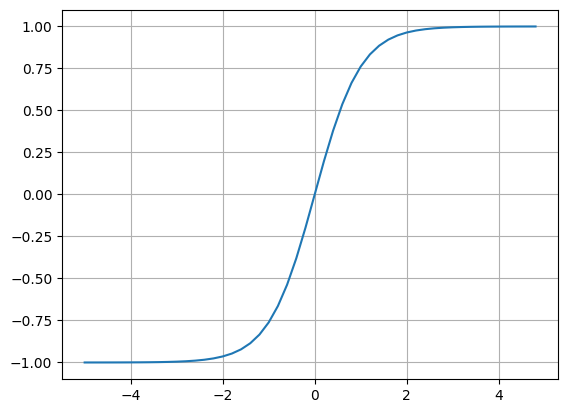

In [45]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

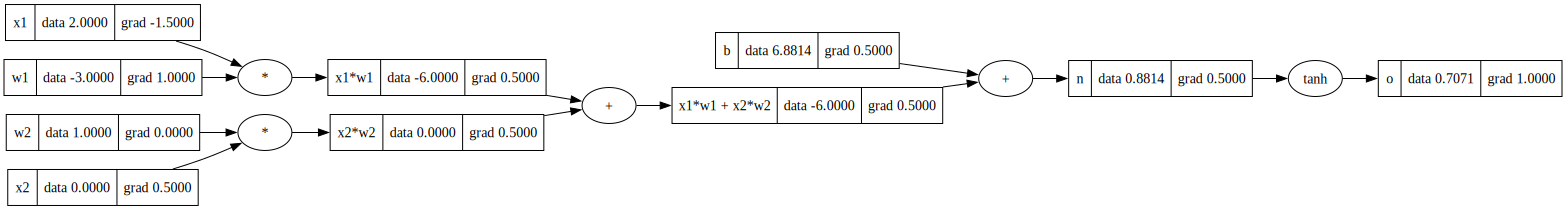

In [68]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.grad = 1.0

o.backward()
    
draw_dot(o)


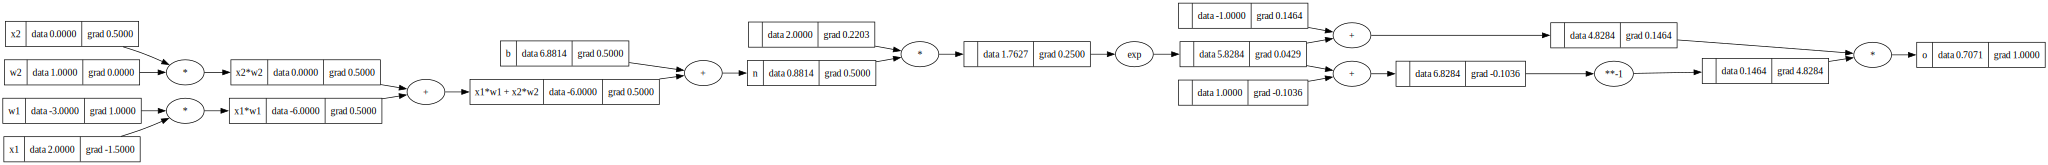

In [10]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2 * n).exp()
o = (e - 1) / (e + 1); o.label = 'o'
o.grad = 1.0

o.backward()
    
draw_dot(o)

In [21]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


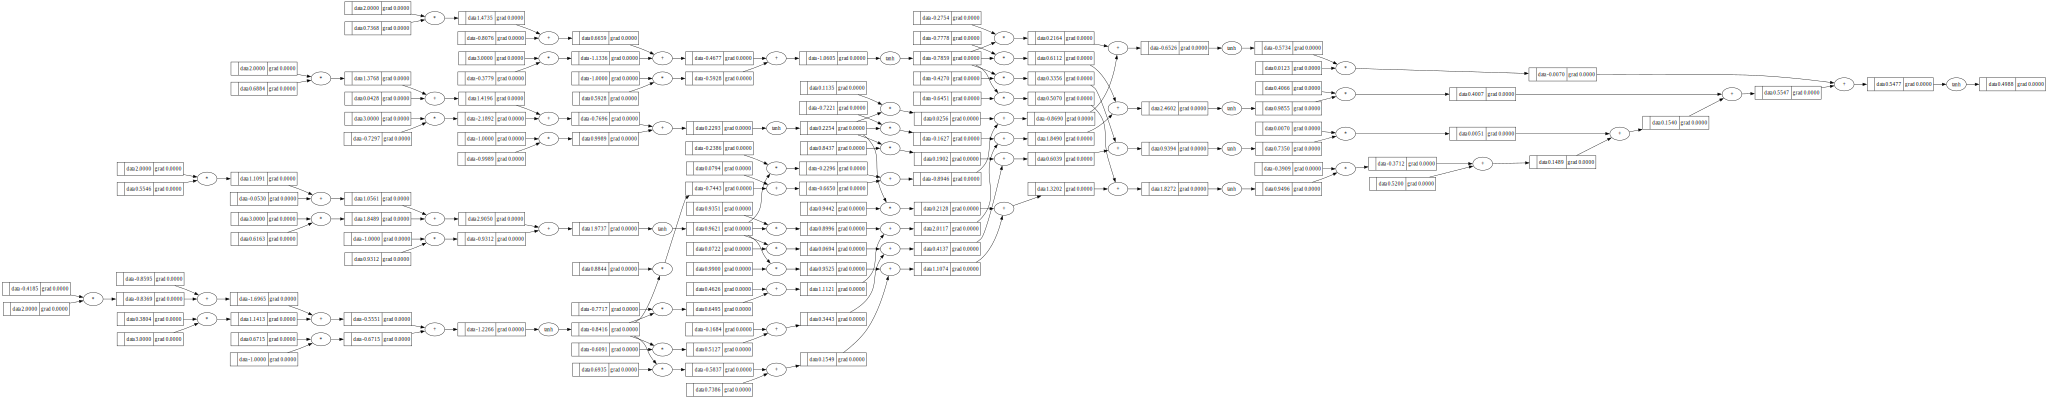

In [61]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x     

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)
draw_dot(n(x))
